# Optimized Model
This model does not show under- or overfitting and performs well on both, training and testing data. Afterwards, a brief description on how to tackle the challenges of an optimal model complexity. 

To address underfitting, one approach is to increase the complexity of the model by adding more layers or increasing the number of filters in each layer. To address overfitting, we can try several approaches. One approach is to simplify the model by removing some layers or decreasing the number of filters in each layer. Another approach is to use less epochs for example.




Adding dropout or weight decay can help to address both of the above mentioned issues. We can also try adjusting the hyperparameters such as learning rate, batch size, or number of epochs.

## GPU Acceleration
We found out that training a model on images can be a very time consuming task, especially if many images are involved. Randomly we stumbled upon an article that stated about "GPU Acceleration" which sounded pretty interesting. Afterwards, we read a bit about the topic and found out that it is possible on our Apple M1 Pro / M2 Pro chips. After a lot of trial and error we ended up using the tensorflow-macos and tensorflow-metal packages but with specific versions because the newest versions did not work. With the both packages installed correctly, both the CPU and GPU are being used for training. The CPU on the M2 Pro chip has 12 cores and a 19 core GPU. The total of 31 cores over 12 cores already indicates that usage of the GPU would lead to massive performance improvements. The following image shows the CPU and GPU usage during training of the optimized model:
![GPU Acceleration](gpu-acceleration.png "GPU Acceleration")

When we were utilizing the CPU only training took ~100s per epoch for the overfitting model (~11'000'000 trainable parameters). After enabling GPU acceleration we came down to astonishing ~10s per epoch. This factor of 10 improvement was even more than we hoped and enabled us to test more parameters because training took about 2 minutes instead of the usual 20 minutes.
TODO + AUTOTUNE für Caching von Images

## Dataset Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15301811002378947930
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 14610404261520837034
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB




2023-03-08 14:26:24.587758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 14:26:24.587878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data Augmentation
Data Augmentation has proven to be a useful tool for model generalization. We've compared the same model with and without data augmentation and the results show that the model without data augmentation tends to overfit while the model with data augmentation doesn't:
![Data Augmentation Result](comparison-data-agumentation.jpg "Data Augmentation Result")

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

img_size = 150
batch_size = 128
seed = 31

train_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    './dataset/seg_train/seg_train',
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)
test_ds = image_dataset_from_directory(
    './dataset/seg_test/seg_test',
    labels="inferred",
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 2666 files belonging to 5 classes.
Using 2133 files for training.


2023-03-08 14:26:24.718481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 14:26:24.718504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2666 files belonging to 5 classes.
Using 533 files for validation.
Found 2499 files belonging to 5 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomRotation, RandomZoom, Rescaling, RandomFlip

data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

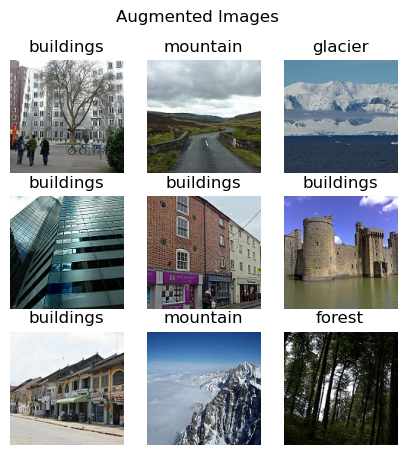

In [11]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea']
def plot_images(title, augment = False):
  plt.figure(figsize=(5, 5))
  plt.suptitle(title)
  for images, labels in train_ds.take(1):
    for i in range(9):
      augmented_images = data_augmentation(images) if augment else images
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

plot_images("Augmented Images", augment=True)

## Building the Model
As a baseline we used the same model as the overfitting one but we add some extras to reduce the overfitting behavior.

### Regularization
Regularization is used to reduce the impact impact of the weights. The weights then end up having less impact on the loss function which determines the error between the actual label and predicted label. This reduces complexity of the model and therefore reduces overfitting. We are adding regularization only to those layers which have the largest number of parameters according to the model summary. We are using L2 (Ridge) regularization since it predetermined from the task. We are adding L2 mainly to the layers that add the most parameters to the CNN.

Dropout Layers: The benefit of using dropout is no node in the network will be assigned with high parameter values, as a a result the parameter values will be dispersed and the output of the current layer will not depend on a single node.
E.g. Dropout(0.2) drops the input layers at a probability of 0.2. Dropout is applied per batch size, so the parameters get tuned for a full batch size with missing input parameters which results in lower generalization errors. 

### Generalization
To improve generalization of the model, data augmentation is a useful tool. With data augmentation we can add artificial effects to the images such as flipping and rotating. Through these effects, the images always appear differently each time they appear in the training step and therefore the CNN doesn't adapt to the exact images but rather learns about the relative features inside of an image.

### Optimizer
For the optimized model we chose Adam over the competitors because it is the most common among SGD. We tried out SGD but it performed very poorly compared to Adam which might be due to insufficient configuration of the learning rate. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order (mean) and second-order (uncentered variance) moments. Its default implementation already provides a form of annealed learning, beta_1=0.9 for the first-order moment and beta_2=0.999 for the second-order moment. 

### Activation Function
The [following article](https://thangasami.medium.com/cnn-and-ann-performance-with-different-activation-functions-like-relu-selu-elu-sigmoid-gelu-etc-c542dd3b1365) states that ReLU is the overall the best suited activation function so based on this we decided to use ReLU for our optimized model.

### Batch Size
The batch size defines how many samples (images here) run through the Neural Network before the weights get adapted. It is recommended to use mini batches to update the Neural Network multiple times during an epoch. We've tried out differnt batch sizes with the same seed on the image generator TODO

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

## Layers
### First Layer
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network because in general, the input values should be small. Therefore we use the Rescaling layer as a normalization layer. 

### Dropout
With Cross-Validation we've tried out different dropout params (0.2, 0.3, 0.4) for the layer before the dense layers. The results are pretty similar but the 0.3 dropout seems to be more stable at the end of 30 epochs so we used this parameter for the model. The steep spikes of accuracy in the first few epochs are expected because due to dropout, some parameters are missing everytime and the model improves a lot over a short period of time because other parameters are being dropped out at every epoch. 
![Last Layer Dropout](cv-dropout-optimization.jpg "Last Layer Dropout")

### Last Layer
For the last layer we tried out 512, 1024 and 2048 trainable parameters and the Cross-Validation result was that the accuracy and loss were not drastically affected but the network with 2048 parameters in the last layer was much more stable than the others. Based on this fact, we sticked with using 2048 parameters in the last layer.
![CV Last Layer](cv-last-layer-param.jpg "CV Last Layer")

### Loss Function
Because we use the SoftMax activation function as the output of the last Dense Layer, we get normalized probabilites, [0, 1]. The SparseCategoricalCrossentry function's from_logits=True would expect Logits which are in the range of [-inf, +inf] and therefore, we use from_logits=False.¨

As the optimizer, we also tried out SGD with annealed learning but in the course of 20 epochs we reached poorer results than with adam.

In [6]:
def create_model(l2_param=0.001, last_dropout_param=0.3, last_layer_param=2048):
    model = Sequential()

    model.add(data_augmentation)
    model.add(Rescaling(1./255))

    model.add(Conv2D(32, (3,3), input_shape= (img_size,img_size, 3), activation = 'relu', padding = 'same')) #padding = same size output
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same')) 
    model.add(MaxPooling2D())

    model.add(Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    model.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    if last_layer_param != 0:
        model.add(Conv2D(last_layer_param, (3,3), activation = 'relu', padding = 'same', kernel_regularizer=l2(l=l2_param))) 
        model.add(MaxPooling2D())

    model.add(Dropout(last_dropout_param))
    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(optimizer = 'adam', loss=SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

    return model

## Cross Validation for Parameter Optimization
To find the optimal L2 regularization parameter we are using a custom implementation for Cross Validation. We tried to use GridSearchCV (as we did in the AI Foundation course) but apparantly, the layer parameters (such as the regularization parameter of the 2nd Conv2D layer) are not accessible from GridSearchCV. With this approach we are fully flexible but have to write if-else statements in the model creation step. With this Cross-Validation implementation we've tuned parameters such as the l2 regularization paramter, the number of trainable parameters in the last Conv2D layer or the percentage of dropout before the dense layers.

The following image visualizes the results of the l2 regularization parameter. The value 0.01 gave the same results for multiple runs and our interpretation is that the penalty was too high to improve the weights of the model and therefore converged almost immediately. The results for l2=0.001 and l2=0001 are pretty similar for the first ~20 epochs but later on the l2=001 parameter performs better on surpressing overfitting:
![l2 Parameter Optimization](cv-l2-optimization.jpg "l2 Parameter Optimization")

In [8]:
import itertools
from sklearn.model_selection import KFold

param_grid=dict(
    # last_layer_param=[512, 1024, 2048]
    # l2_param=[0.01, 0.001, 0.0001],
    # last_dropout_param=[0.2, 0.3, 0.4]
    last_dropout_param=[0.4]
)
epochs = 1

keys = list(param_grid.keys())
params = list(param_grid.get(x) for x in keys)
param_permutations = list(itertools.product(*params))

model_history = []

train_images = np.concatenate(list(train_ds.map(lambda x, y:x)))
train_labels = np.concatenate(list(train_ds.map(lambda x, y:y)))

val_images = np.concatenate(list(val_ds.map(lambda x, y:x)))
val_labels = np.concatenate(list(val_ds.map(lambda x, y:y)))

inputs = np.concatenate((train_images, val_images), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)

kfold = KFold(n_splits=5, shuffle=True)

for train, test in kfold.split(inputs, targets):

    for perm in param_permutations:
        model_args = dict()
        for index in range(len(params)):
            key = keys[index]
            value = perm[index]
            model_args[key] = value

            
        print("CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:")
        print(model_args)
        model = create_model(**model_args)
        history = model.fit(inputs[train], targets[train], epochs=epochs)
        #%run rueegg_wissiak_model_visualization.ipynb
        scores = model.evaluate(inputs[test], targets[test])
        print(scores)
        model_history.append(dict(history=history, model=model))

CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:
{'last_dropout_param': 0.4}


2023-03-08 14:26:36.143236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/17 [======>.......................] - ETA: 0s - loss: 1.7999 - accuracy: 0.2188

2023-03-08 14:26:47.939688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 37ms/step - loss: 1.7991 - accuracy: 0.2060
[1.7991002798080444, 0.20599250495433807]
CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:
{'last_dropout_param': 0.4}


2023-03-08 14:26:49.350071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/17 [======>.......................] - ETA: 0s - loss: 1.7472 - accuracy: 0.2109

2023-03-08 14:27:01.154992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 23ms/step - loss: 1.7467 - accuracy: 0.2101
[1.7466928958892822, 0.21013133227825165]
CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:
{'last_dropout_param': 0.4}


2023-03-08 14:27:02.693516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/17 [====>.........................] - ETA: 0s - loss: 1.6926 - accuracy: 0.2292

2023-03-08 14:27:14.802706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 24ms/step - loss: 1.6928 - accuracy: 0.2270
[1.6928402185440063, 0.227016881108284]
CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:
{'last_dropout_param': 0.4}


2023-03-08 14:27:16.028999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/17 [>.............................] - ETA: 3s - loss: 1.6496 - accuracy: 0.2500

2023-03-08 14:27:28.401262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 27ms/step - loss: 1.6521 - accuracy: 0.2120
[1.6521052122116089, 0.21200750768184662]
CURRENTLY TRAINING THE MODEL WITH THE FOLLOWING PARAMS:
{'last_dropout_param': 0.4}


2023-03-08 14:27:29.913570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/17 [>.............................] - ETA: 3s - loss: 1.6703 - accuracy: 0.1875

2023-03-08 14:27:41.617790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 1s 25ms/step - loss: 1.6739 - accuracy: 0.1932
[1.6739459037780762, 0.1932457834482193]


## Training the Model

In [9]:
model = create_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                 

In [10]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/30


2023-03-08 14:27:42.638675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 2.6537 - accuracy: 0.2583

2023-03-08 14:27:59.010242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 17s 959ms/step - loss: 2.6537 - accuracy: 0.2583 - val_loss: 1.8236 - val_accuracy: 0.3283
Epoch 2/30
17/17 [==============================] - 15s 866ms/step - loss: 1.5459 - accuracy: 0.3952 - val_loss: 1.6633 - val_accuracy: 0.3977
Epoch 3/30
 8/17 [=============>................] - ETA: 8s - loss: 1.3602 - accuracy: 0.4688

KeyboardInterrupt: 

In [ ]:
%run rueegg_wissiak_model_visualization.ipynb

: 

In [ ]:
model.evaluate(test_ds)

: 